<a href="https://colab.research.google.com/github/suneelkumarpentela/Normalizer-free-models/blob/master/BN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn
from sklearn.metrics import classification_report, confusion_matrix,precision_recall_fscore_support

In [2]:
os.getcwd()

'/content'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir("/content/drive/MyDrive/Colab Notebooks/Mathlogic")

In [5]:
train = pd.read_csv("./Data/train.csv")
print(train.shape)

(90000, 95)


In [6]:
train['target_new'] = np.where(train['target']==0,0,1)
train.drop(['target'],axis=1,inplace=True)

In [7]:
val = pd.read_csv("./Data/valid.csv")
print(val.shape)
val['target_new'] = np.where(val['target']==0,0,1)
val.drop('target',axis=1,inplace=True)

(29000, 95)


In [8]:
test = pd.read_csv("./Data/test.csv")
print(test.shape)
test['target_new'] = np.where(test['target']==0,0,1)
test.drop('target',axis=1,inplace=True)

(29580, 95)


In [9]:
frames = [train,test]
X = pd.concat(frames)

In [10]:
X_train = X.drop('target_new',axis=1)
y_train = np.array([X['target_new']]).reshape(-1,1)
X_train.shape

(119580, 94)

In [11]:
X_test = val.drop('target_new',axis=1)
y_test = np.array([val['target_new']]).reshape(-1,1)
X_test.shape

(29000, 94)

In [12]:
a = y_test.flatten()

In [13]:
from collections import Counter

In [14]:
Counter(y_test.flatten())

Counter({0: 27488, 1: 1512})

In [15]:
Counter(y_train.flatten())

Counter({0: 113300, 1: 6280})

In [16]:
6280/(6280+113300)

0.05251714333500585

In [17]:
y_test.shape

(29000, 1)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_train_np = scaler.transform(X_train)

X_test_np = scaler.transform(X_test)

In [19]:
y_train_np = y_train
y_test_np = y_test

In [20]:
X_train = torch.FloatTensor(X_train_np)

X_test = torch.FloatTensor(X_test_np)

y_train = torch.FloatTensor(y_train_np)
y_test = torch.FloatTensor(y_test_np)

In [21]:
print(y_train.shape)

torch.Size([119580, 1])


In [22]:
X_train_np.shape

(119580, 94)

In [23]:
X_test_np.shape

(29000, 94)

In [24]:
batch_size = 256
num_train_batches = int(X_train_np.shape[0]/batch_size)+1
num_test_batches = int(X_test_np.shape[0]/batch_size)+1
train_data_size = X_train_np.shape[0]
test_data_size = X_test_np.shape[0]
print("Train :",num_train_batches,train_data_size)
print("Test :",num_test_batches,test_data_size)

Train : 468 119580
Test : 114 29000


In [25]:
train_dataset = TensorDataset(X_train,y_train)
train_dataloader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [26]:
test_dataset = TensorDataset(X_test,y_test)
test_dataloader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [27]:
train_loader = DataLoader(train_dataset)
test_loader = DataLoader(test_dataset)

In [28]:
# dataiter = iter(train_dataloader)
# images, labels = dataiter.next()
# print(type(images))
# print(images.shape)
# print(labels.shape)

In [29]:
class basic_block(nn.Module):

  def __init__(self):
    super().__init__()
    self.nn1 = nn.Linear(94,64)
    self.nn2 = nn.Linear(64,64)
    self.nn3 = nn.Linear(64,64)
    self.nn4 = nn.Linear(64,1)
    self.bn1  = nn.BatchNorm1d(64)
    self.bn2  = nn.BatchNorm1d(64)
    self.bn3  = nn.BatchNorm1d(64)
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self,x):

    x = self.nn1(x)
    x = self.bn1(x)
    x = self.relu(x)

    shortcut1 = x

    out1 = self.nn2(x)
    out1 = self.bn2(out1)
    out1 += shortcut1
    out1 = self.relu(out1)

    shortcut2 = out1

    out2 = self.nn3(out1)
    out2 = self.bn3(out2)
    out2 += shortcut2
    out2 = self.relu(out2)

    out3 = self.nn4(out2)
    out3 = self.sigmoid(out3)

    return out3

In [30]:
model = basic_block()

In [31]:
total_params = sum(p.numel() for p in model.parameters())
total_params

14849

In [32]:
print(model.forward)

<bound method basic_block.forward of basic_block(
  (nn1): Linear(in_features=94, out_features=64, bias=True)
  (nn2): Linear(in_features=64, out_features=64, bias=True)
  (nn3): Linear(in_features=64, out_features=64, bias=True)
  (nn4): Linear(in_features=64, out_features=1, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)>


In [33]:
# loss_func = nn.BCELoss(reduction="sum")
loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001)

In [34]:
X_train_np.shape

(119580, 94)

In [35]:
epochs = 100

In [36]:
losses = []
accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(epochs):

  model.train()
  running_loss = 0
  running_val_loss = 0
  running_acc = 0
  running_val_acc = 0

  for i,data in enumerate(train_dataloader):
    train_x,train_y = data
    y_pred = model(train_x)
    loss = loss_func(y_pred,train_y)
    # predicted = model(torch.tensor(X_train_np,dtype=torch.float32))
    acc = (y_pred.reshape(-1).detach().numpy().round() == 
           train_y.reshape(-1).detach().numpy().round()).mean()
    running_loss += loss.item()/(num_train_batches)
    running_acc += acc/(num_train_batches)
    
    #reset grads
    optimizer.zero_grad()
    
    #backward
    loss.backward()

    #weight updates
    optimizer.step()

  print(f'Epoch: {epoch+1} Loss: {running_loss} Accuracy: {running_acc}',end = " ")

  model.eval()  
  for i,data in enumerate(test_dataloader):
    X_val,y_val = data
    y_pred_val = model(X_val)
    val_loss = loss_func(y_pred_val,y_val)
    val_acc = (y_pred_val.reshape(-1).detach().numpy().round() == 
           y_val.reshape(-1).detach().numpy().round()).mean()

    running_val_loss += val_loss.item()/(num_test_batches)
    running_val_acc += val_acc/(num_test_batches)
    
  print(f'Val Loss: {running_val_loss} Val Accuracy: {running_val_acc}')


  losses.append(running_loss)
  accuracy.append(running_acc)
  val_losses.append(running_val_loss)
  val_accuracy.append(running_val_acc)  

Epoch: 1 Loss: 0.3247496515958227 Accuracy: 0.9101550576159959 Val Loss: 0.23050262230007268 Val Accuracy: 0.9475778204191031
Epoch: 2 Loss: 0.21972554543206826 Accuracy: 0.9472429697039089 Val Loss: 0.21217006013581616 Val Accuracy: 0.9479280884502922
Epoch: 3 Loss: 0.209853544035274 Accuracy: 0.9474468673687441 Val Loss: 0.20577763870619895 Val Accuracy: 0.9480156554580892
Epoch: 4 Loss: 0.20564812310358382 Accuracy: 0.9475148332570207 Val Loss: 0.20364750189739356 Val Accuracy: 0.9475778204191034
Epoch: 5 Loss: 0.2025868357119398 Accuracy: 0.947514833257021 Val Loss: 0.1995471622468085 Val Accuracy: 0.9481907894736837
Epoch: 6 Loss: 0.20077003799697277 Accuracy: 0.947514833257022 Val Loss: 0.19849075801801266 Val Accuracy: 0.9479280884502923
Epoch: 7 Loss: 0.19918047802315839 Accuracy: 0.947514833257022 Val Loss: 0.19841602719143817 Val Accuracy: 0.9474026864035086
Epoch: 8 Loss: 0.19803441344545444 Accuracy: 0.9474468673687431 Val Loss: 0.19629322489102674 Val Accuracy: 0.947840521

Text(0, 0.5, 'loss')

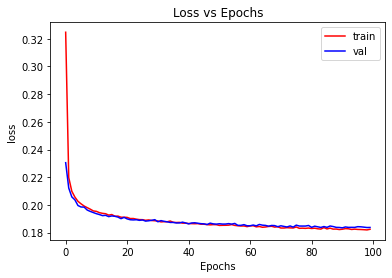

In [37]:
plt.plot(losses,'r',label='train')
plt.plot(val_losses,'b',label='val')
plt.legend()
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')

Text(0, 0.5, 'loss')

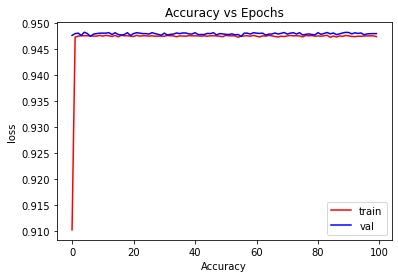

In [38]:
plt.plot(accuracy,'r',label='train')
plt.plot(val_accuracy,'b',label='val')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.xlabel('Accuracy')
plt.ylabel('loss')

In [39]:
model.eval()
preds_train = []
with torch.no_grad():
   for i,data in enumerate(train_loader):
     trainx,trainy = data
     y_hat = model.forward(trainx)
     preds_train.append(y_hat)

In [40]:
preds_train = np.array(preds_train)
preds_train

array([0.06040598, 0.00197853, 0.03175104, ..., 0.00980924, 0.01729902,
       0.05139145], dtype=float32)

In [41]:
def best_f1(preds,y_test_np):
  f1_max = 0
  cutoff = -1
  for i in np.arange(0.01,1,0.01):
    preds1 = (preds>=i)*1 
    #print(sum(preds1))
    f1_score = sklearn.metrics.precision_recall_fscore_support(preds1,y_test_np)[2][1]
    print(f1_score)
    if (not f1_score):
      break
    if (f1_score > f1_max):
      f1_max = f1_score
      cutoff = i
  return cutoff,f1_max

In [42]:
train_cutoff,train_f1 = best_f1(preds_train,y_train_np)

0.12070643040363238
0.1395964195044041
0.1555445893549524
0.1699331372903353
0.1825239762520932
0.19500855300671083
0.20535444186750026
0.21441656247274
0.22122173334697637
0.22674912089244575
0.23016898846282735
0.22832838994907378
0.22744239927918652
0.22277191706074936
0.21334197941152633
0.20257695060844666
0.18574472206081735
0.17084069417021722
0.15837855797984274
0.14337419731465265
0.12868501529051987
0.11876907426246185
0.1071898867526995
0.0983073798239675
0.08262623452496871
0.07273760477340531
0.06468455402465555
0.055342949661466
0.04719235364396655
0.03955314009661835
0.03352125552338869
0.028531983433041877
0.02620221948212084
0.02320185614849188
0.020531964535697618
0.01840012474660845
0.015014075695964968
0.012248743718592964
0.01132966168371361
0.009457755359394703
0.007580543272267846
0.00663716814159292
0.005694400506168934
0.004432483773943327
0.004117181314330957
0.003169572107765452
0.002854424357754519
0.0028548770816812052
0.0028553299492385786
0.00222186954451

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
train_cutoff,train_f1

(0.11, 0.23016898846282735)

In [44]:
preds_train_ideal = (preds_train>=train_cutoff)*1

In [45]:
print(classification_report(preds_train_ideal,y_train_np))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93    104971
           1       0.38      0.16      0.23     14609

    accuracy                           0.87    119580
   macro avg       0.64      0.56      0.58    119580
weighted avg       0.83      0.87      0.84    119580



In [46]:
model.eval()
preds = []
with torch.no_grad():
   for i,data in enumerate(test_loader):
     test_x,test_y = data
     y_hat = model.forward(test_x)
     preds.append(y_hat)

In [47]:
np.array(preds)

array([0.01258692, 0.01299697, 0.1805474 , ..., 0.08722918, 0.08851077,
       0.14764693], dtype=float32)

In [48]:
preds = np.array(preds)
np.unique(preds)

array([9.6162848e-06, 5.6802673e-05, 8.3449238e-05, ..., 5.4567313e-01,
       5.5683380e-01, 6.1660248e-01], dtype=float32)

In [49]:
preds_dummy = (preds>=0.5)*1

In [50]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)

(array([0.99992724, 0.00132275]),
 array([0.94792385, 0.5       ]),
 array([0.97323136, 0.00263852]),
 array([28996,     4]))

In [51]:
sklearn.metrics.precision_recall_fscore_support(preds_dummy,y_test_np)[2][1]

0.002638522427440633

In [52]:
np.arange(0.01,1,0.01)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])

In [53]:
cutoff,f1_max = best_f1(preds,y_test_np)

0.11820541943858509
0.13657190717840076
0.15276886269475407
0.1662820686846749
0.17770825185764566
0.18710720057460944
0.19157873168732711
0.19651947436959866
0.20564908863225265
0.21256198347107438
0.21522207004500096
0.21551132463967054
0.21049840933191943
0.20316701523752612
0.19752259792433882
0.18155090040426317
0.17585931254996
0.167453842851009
0.15576036866359447
0.14417924987822697
0.1327207759060745
0.11205073995771668
0.10038188761593016
0.0931537598204265
0.08735632183908046
0.07971864009378662
0.07619047619047618
0.06751054852320675
0.05162876459741856
0.0460772104607721
0.03780718336483932
0.031746031746031744
0.026837060702875396
0.024484536082474227
0.020711974110032363
0.016894087069525665
0.014341590612777051
0.013054830287206266
0.009162303664921465
0.006557377049180327
0.005252790544977018
0.0052596975673898745
0.005263157894736841
0.005263157894736841
0.003949967083607636
0.003952569169960474
0.002638522427440633
0.002638522427440633
0.002638522427440633
0.00263852

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
print(cutoff,f1_max)

0.12 0.21551132463967054


In [55]:
preds_ideal = (preds>=cutoff)*1

In [56]:
print(classification_report(preds_ideal,y_test_np))

              precision    recall  f1-score   support

           0       0.91      0.96      0.94     26141
           1       0.31      0.16      0.22      2859

    accuracy                           0.88     29000
   macro avg       0.61      0.56      0.58     29000
weighted avg       0.85      0.88      0.87     29000

